# Vehicle Detection

This project will demonstrate how I setup pipeline to detect the vehicle so I will start with sample images and along the way, I will apply that to a series of images or video. 

At the end, you will see the video with vehicle detection.

Let walk through the steps

* Explore data
* Choose color features
* Choose gradient features based on HOG
* Train classifiers to detect cars and non-cars
* Implement sliding windows to scan the images
* Search and Classify
* Tracking pipeline
* Summary

## Let explore the data

Let look at training data we're going to use to build the classifier.

I examined the car and non-car of data download from [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images, just a sample of data

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
import vehicle_detection as my_function 
import glob
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


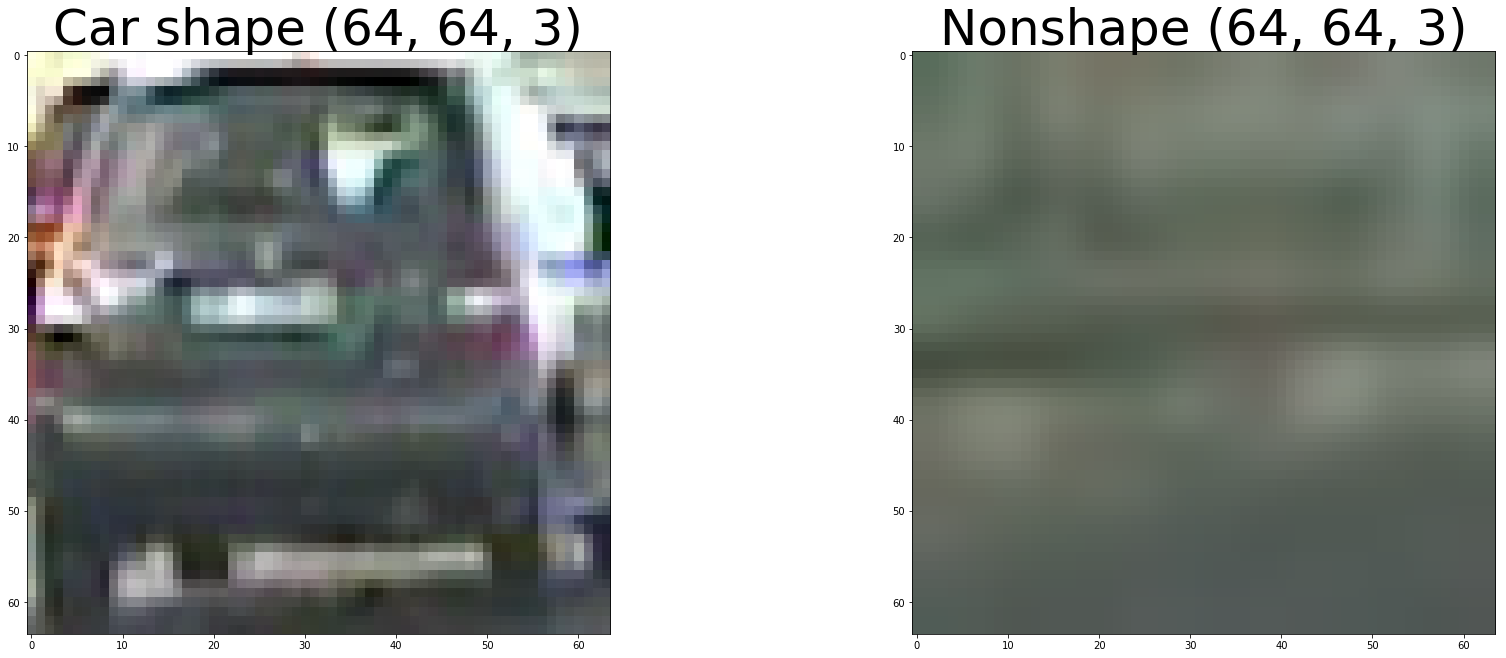

In [2]:
img1 = my_function.read_image('./test_images/car_1.png')
img2 = my_function.read_image('./test_images/noncar_1.png')
my_function.display_2_images(img1, img2, 
                             text_1='Car shape {}'.format(img1.shape), 
                             text_2='Nonshape {}'.format(img2.shape))

## Color Features

First, we look at color features aka channels (RGB, HSV, LUV, HLS, YUV, and YCrCb) 

By the help of `extract_features` function, allow me to experiment with varieties of parameters including HOG but we will look that shortly.

* Spatial Binning of Color
Simply said resize the image to smaller ratio while still having all relevant data

* Histogram of Color
Use histogram of color so I can focus on the overall magnitude of each color channels so the image of the car rotates horizontally or vertically, the histogram will be the same.

Last but not least, it's very important we normalize data which can be compared with the picture below between `Raw Features` and `Normalized Features`  I'll revisit it again at the train classifiers section.

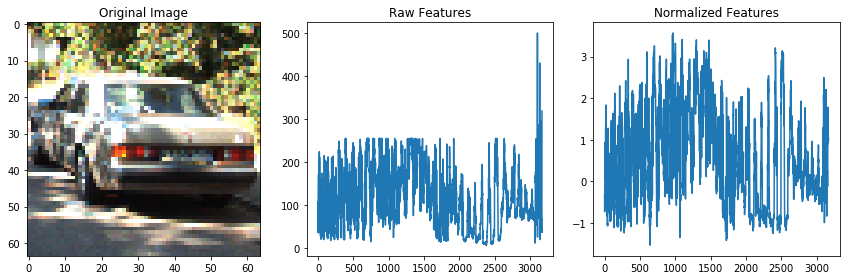

In [3]:
images = glob.glob('./test_images/*car*.png')
cars = []
notcars = []
for image in images:
    if 'noncar' in image:
        notcars.append(image)
    else:
        cars.append(image)                
        
car_features = my_function.extract_features(cars, color_space='RGB', 
                        spatial_size=(32, 32),hist_bins=32, 
                        spatial_feat=True, hist_feat=True, hog_feat=False)
notcar_features = my_function.extract_features(notcars, color_space='RGB', 
                        spatial_size=(32, 32),hist_bins=32, 
                        spatial_feat=True, hist_feat=True, hog_feat=False)   

X = np.vstack([car_features, notcar_features]).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## HOG Feature

HOG or Histogram of Oriented Gradients provides me the distribution (histogram) of directions of gradients (oriented gradients) which I will use as another feature in addition to Color features.

Below is an example of code getting HOG features and image features in each channel with parameters of both Car and Non-car

* Color Space HSV
* Orient 9 (9 buckets of histogram)
* 4 Pixel per cell
* 2 Cell per block

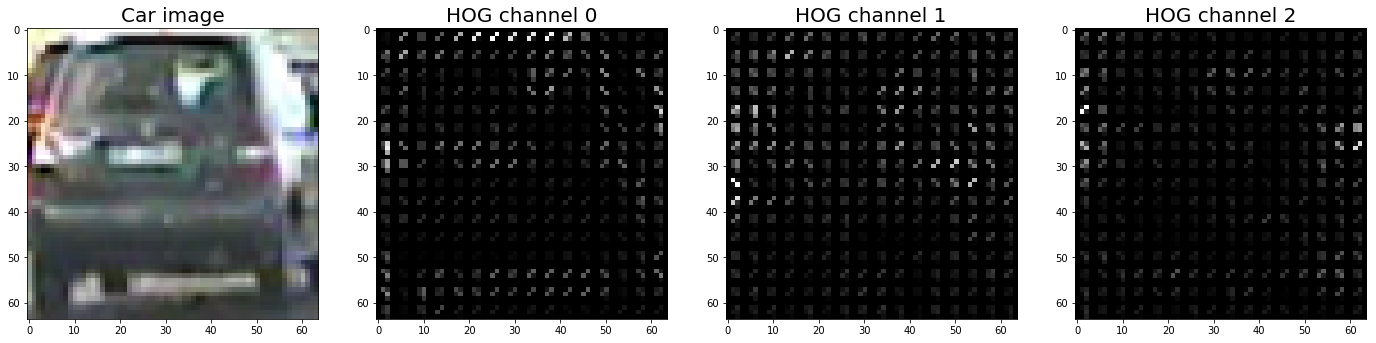

In [4]:
car_image = my_function.read_image('./test_images/car_1.png')
car_image_ycrcb = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

f, (*ax) = plt.subplots(1, 4, figsize=(24, 9))
ax[0][0].imshow(car_image)
ax[0][0].set_title("Car image", fontsize=20)
for i in range(3):
    hog_features, img_feature = my_function.get_hog_features(
        car_image_ycrcb[:,:,i], 
        orient=9,pix_per_cell=4, cell_per_block=2, 
        vis=True, feature_vec=False)   
    ax[0][i+1].imshow(img_feature, cmap='gray')
    ax[0][i+1].set_title("HOG channel {}".format(i), fontsize=20)    


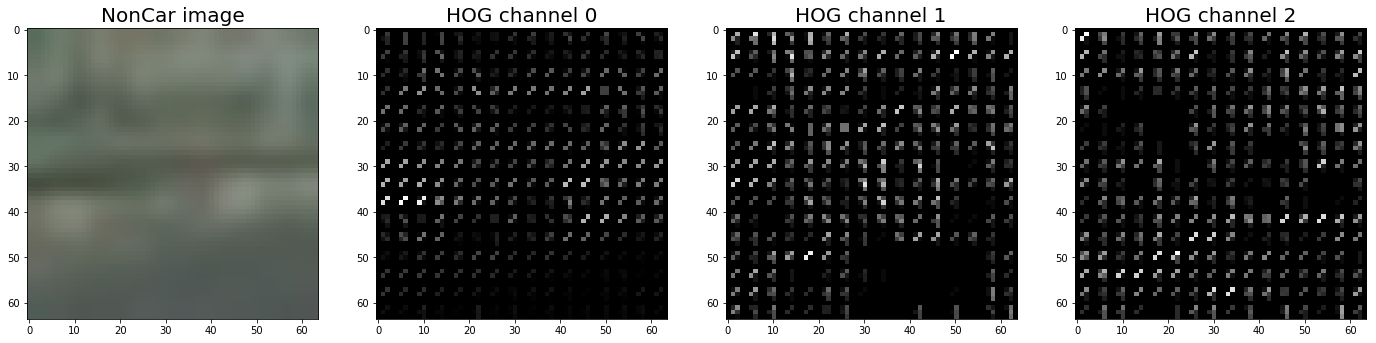

In [5]:
noncar_image = my_function.read_image('./test_images/noncar_1.png')
noncar_image_ycrcb = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2YCrCb)

f, (*ax) = plt.subplots(1, 4, figsize=(24, 9))
ax[0][0].imshow(noncar_image)
ax[0][0].set_title("NonCar image", fontsize=20)
for i in range(3):
    hog_features, img_feature = my_function.get_hog_features(
        noncar_image_ycrcb[:,:,i], orient=9,
        pix_per_cell=4, cell_per_block=2, 
        vis=True, feature_vec=False)   
    ax[0][i+1].imshow(img_feature, cmap='gray')
    ax[0][i+1].set_title("HOG channel {}".format(i), fontsize=20)    

Here is data between normalized data and raw data, I just want to point out how important it is to visualize data before going to training classifier step.

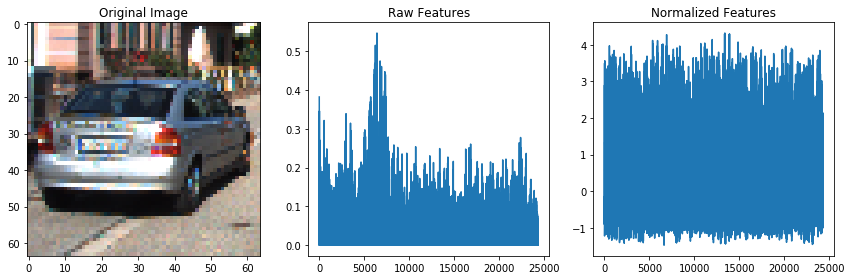

In [6]:
images = glob.glob('./test_images/*car*.png')
cars = []
notcars = []
for image in images:
    if 'noncar' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = my_function.extract_features(cars, color_space='YCrCb', 
                        orient=9,
                        pix_per_cell=4, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)
notcar_features = my_function.extract_features(notcars, color_space='YCrCb', 
                        orient=9,
                        pix_per_cell=4, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)

X = np.vstack([car_features, notcar_features]).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### Train classifiers

At this step, I will show how I use the color and hog features extracted from earlier step and train my classifier with `Support Vector Machine` or `SVM` or to be more specific [Linear SVC](http://scikit-learn.org/stable/modules/svm.html#svc)

First, let talk about how I come up with what parameters to use to extract both Color and HOG features.

I decide to experiment with all combination of parameters by implementing a function `experiment_color` and `experiment_hog` by passing list of parameters (please see this function in `vehicle_detection.py` for more information)

#### Experiment with Color and HOG 

```
## Try all combination of Colors, Spatial and Histogram Bin 
experiment_color(cars, noncars, 
    ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'],
    [8, 16, 32], [8, 16,32]
    )
    
## Try all combination    
experiment_hog(cars, noncars,
    ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'],
    [9,12], [2,4,6,8], [2,4], [0,1,2,'ALL']
    )    
```

From above I can pass all parameters and let my classifier tried all combination and gave me the most accuracy parameters it could get.

I chose these parameters for my final classifier based on my experiment.

    color_space = 'YCrCb'
    hist_bins = 16
    spatial = (16,16)
    orient = 9
    pix_per_cell = 4
    cell_per_block = 2
    hog_channel = 'ALL'

#### Train the classfiers

Once we extract features of color and hog on both set of cars and non-cars images with the help of `extract_features` function I will get a very long vector of features value which will be passed into my classifier.

##### Training in details

*Normalize data* is very important like mentioned above to avoid outliers, bias or unbalance in the data itself, I implemented `normalize_data` function to get input of features and stack it up together before using [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to create scaler and normalize my car and non-car features then return  these data along with scaler out so, later on, we use the same scaler to my pipeline when classifying images.

*Splitting data* it's always a good practice to divide data into training and validation only so when predicting we want to make sure a classifier can predict unseen data.

Here is the snippet of code to normalize data, splitting data for training and validation then train my SVM classifier.

```
def normalize_data(car_features, noncar_features):
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    return X_scaler.transform(X), X_scaler
    
# define labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))    
    
# Normalize data
scaled_X, X_scaler = normalize_data(car_features, noncar_features) 

# good idea to split data into training and validation and random
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Time to train it
svc = LinearSVC()
svc.fit(X_train, y_train)
```

This is an example of training classifier with only 10 of the car and 10 non-car images only just for purpose of demonstration.

In [7]:
images = glob.glob('./test_images/*car*.png')
cars = []
notcars = []
for image in images:
    if 'noncar' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# train classifier
color_space = 'YCrCb'
hist_bins = 16
spatial = (16,16)
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = 'ALL'    

car_features = my_function.extract_features(cars, 
                    color_space=color_space, spatial_size=spatial, hist_bins=hist_bins,
                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
noncar_features = my_function.extract_features(notcars, 
                   color_space=color_space, spatial_size=spatial, hist_bins=hist_bins,
                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

svc, X_scaler, pred = my_function.train_classifier(car_features, noncar_features, visualize=True)

Test Accuracy of SVC =  0.75
My SVC predicts:  [ 1.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  1.]


### Implement sliding windows to scan the images

At this step, we have classifiers with optimum features we choose from above experiments already. Now I will start using my classifiers to image however I don't know what location to look for so I will use sliding windows to move and overlap each others to scan over the image avoid the area I know there is no car for sure (sky, tree) so I start at location of y value of 400 until the bottom of the image.

The snippet code below shows sliding windows of size 128*128 pixels with 25% each overlap both horizontal and vertical direction.

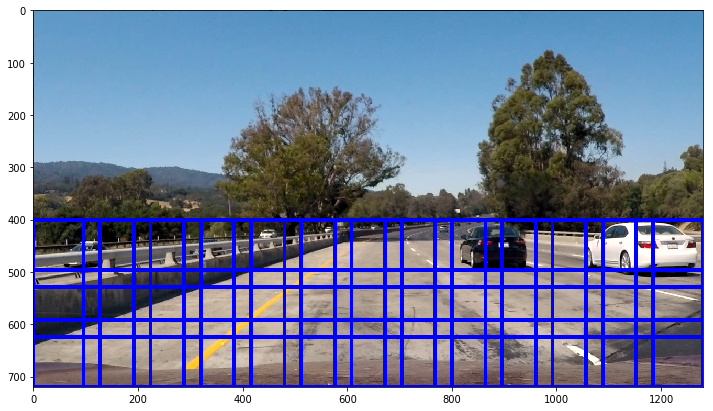

In [8]:
test_image = my_function.read_image('./test_images/test1.jpg')
window_list = my_function.slide_window(test_image,y_start_stop=[400,None],xy_window=(128, 128), xy_overlap=(0.25, 0.25))
window_image = my_function.draw_boxes(test_image, window_list)
plt.figure(figsize=(12,12))
plt.imshow(window_image)

### Search and classify

At this stage, I have all I need to classify single image so I will use all methods I mentioned before and classify images.

#### Save and Load saved state
One thing to be noted, I introduced `save_state` and `load_state` into my training pipeline so I can reuse my classifier once it was trained (and trust me it's worth it) because training all images 1x,xxx combined lasts for at least 5 minutes on my humble machine.

I saved all even include color_space, hist_bins, spatial, orient, pix_per_cell, cell_per_block and hog_channel parameters just to make sure I classify data using the same parameters as when I trained it.

#### Classify the car 

The steps are
* create 3 sliding windows small, medium and large to detect car in different area of image (bigger window to detect car closer to camera)
* using above sliding windows list to `search_windows` which internally call extract features for the single image file 
* Load saved states
* Classify the image and return list of windows that classified as 1 or it's car

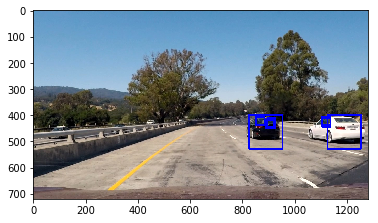

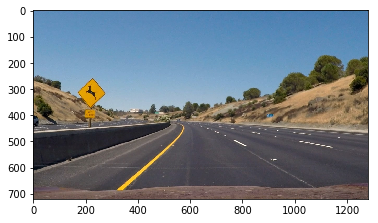

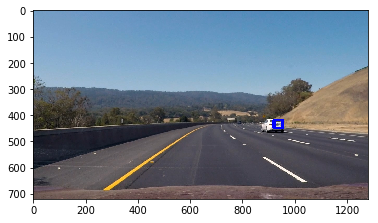

In [17]:
images = glob.glob('./test_images/*.jpg')
for image in images[:3]:
    test_image = my_function.read_image(image)
    window_list_s = my_function.slide_window(test_image,
                         y_start_stop=[400,450], xy_window=(32,32), 
                                             xy_overlap=(0.8,0.8))
    window_list_m = my_function.slide_window(test_image,
                         y_start_stop=[400,600], xy_window=(128,128), 
                                             xy_overlap=(0.8,0.8))
    window_list_l = my_function.slide_window(test_image,
                         y_start_stop=[450,None], xy_window=(256,256), 
                                             xy_overlap=(0.8,0.8))
    windows = window_list_s + window_list_m + window_list_l

    # Load all saved states trained SVC, and all params    
    svc, X_scaler,color_space, spatial, hist_bins,orient, pix_per_cell, cell_per_block,hog_channel = my_function.load_state('training_ALL_YCrCb.p')
    
    hot_windows = my_function.search_windows(test_image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                 hog_channel=hog_channel)

    window_image = my_function.draw_boxes(test_image, hot_windows, color=(0,0,255))
    plt.imshow(window_image)
    plt.show()

#### Classify the car improved version

This is another improved version of above code because it took me at least 5-10 seconds per image to classify which is ok for the very small amount of images but for video, it will take forever.

Let introduce `find_car` function which is run HOG on the whole image once and reuse it throughout the list of windows I want to classify. 

Before I run HOG feature extraction for every list of windows while the improved version it extracted HOG feature once. So for now until the end of the pipeline, I will use this improved version of classify method and use the word interchangeably with the sliding_windows method.

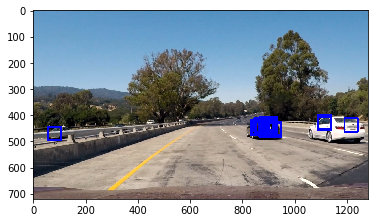

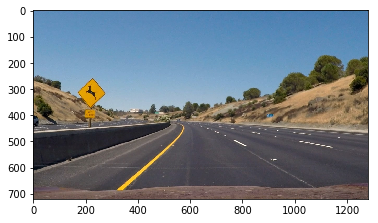

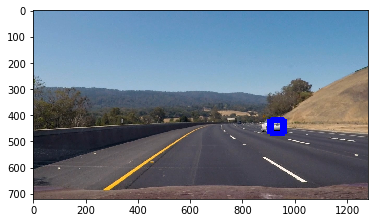

In [20]:
images = glob.glob('./test_images/*.jpg')
for image in images[:3]:
    test_image = my_function.read_image(image)
    
    # Load all saved states trained SVC, and all params
    svc, X_scaler, color_space, spatial, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel = my_function.load_state(
        'training_ALL_YCrCb.p')

    ystart = 400
    ystop = 592
    scale = 0.8
    hot_windows = my_function.find_cars(test_image, ystart, ystop, scale, svc, X_scaler,
                     color_space, orient, pix_per_cell, cell_per_block,
                     spatial, hist_bins)

    window_image = my_function.draw_boxes(test_image, hot_windows, color=(0,0,255))
    plt.imshow(window_image)
    plt.show()

#### Multiple Detections & False Positive

I have a list of detect windows classified as before however they're overlapped and some even show as a car that barely a car which I will filter out with the technique in this section.

By using Heatmap and [Labels](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html)

```
# how many boxes repeat enough to keep it
heatmap_threshold = 2  

#Create blank heatmap same size as image
heatmap = np.zeros_like(image_detection[:, :, 0]).astype((np.float))

# add list of windows +1 per one bbox_list 
heatmap = add_heat(heatmap, bbox_list)

# filter out (set to zero) the heatmap count that less than threshold
heatmap = apply_threshold(heatmap, heatmap_threshold)

# min and max heatmap between 0 and 255
heatmap = np.clip(heatmap, 0, 255)

# labels the data, group them up if they are next to each other 
# this is to create a single area of window
labels = label(heatmap)
```

To save some space here, the detail code is in `detection_pipeline` just reference it for more.

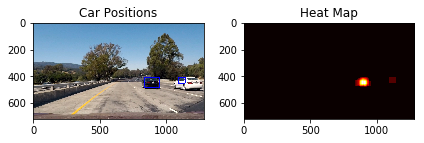

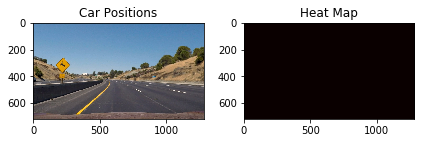

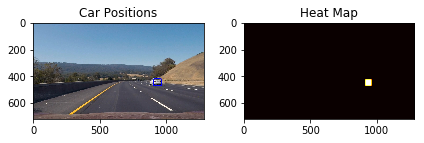

In [25]:
images = glob.glob('./test_images/*.jpg')
for image in images[:3]:
    test_image = my_function.read_image(image)
    
    # Load all saved states trained SVC, and all params
    svc, X_scaler, color_space, spatial, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel = my_function.load_state(
        'training_ALL_YCrCb.p')

    ystart = 400
    ystop = 592
    scale = 0.8
    my_function.detection_pipeline(test_image,[(ystart, ystop, scale)], 
                                   svc, X_scaler, color_space, 
                                   orient, pix_per_cell, 
                                   cell_per_block, spatial, 
                                   hist_bins, heatmap_threshold=1,
                                   visualize=True)

### Tracking Pipeline

I have everything I need to use this pipeline to detect a car in the video but to smooth it up, I add `Tracking` class to keep the last 10 frames of heatmap while everything is the same as detecting single images.

For final product, I have included 2 videos [vehicle_detection_final.mp4](./vehicle_detection_final.mp4) for longer version and [vehicle_detection_small.mp4](./vehicle_detection_small.mp4)

### Summary

I will summary each topic I found it very useful for anyone to start this journey and how I resolve it.

**Confusing of reading image** whether I work with png or jpeg file it's very confusing to remember that Matplotlib image read will provide a range of 0-255 for jpeg and 0-1 for png file. It caused me an error every now and then when I forgot about this or some logic somewhere that cannot handle same range of value. So I end up creating one `read_image` to always convert to 255 range no matter what format it reads.

**Experiment feature extraction** the first couple of hours when deciding which parameters to use they are overwhelming and sometimes hard to keep track of data. To resolve this, I create a method given a list of each parameters list and let classifier fit, train and predict it then based on purely data I choose the best one.

**Training classifier and states** first version I work on classifier and train it every time I run it, it's 10-15 seconds for a small number of images but when it added up you will lose an hour very quickly. Let's train and serialize it. My full training classifier of all images took me almost an hour. Once trained, I can load all saved `SVC` and all trained parameters to extract other data as well.

**HOG Subsampling** HOG process is very slow, I mean very very slow the more sliding windows you have the more time spending on HOG feature extraction. I considered using HOG sub-sampling just to speed this process up and well worth it (although it's not easy to understand or change logic)

**Visualize, visualize and visualize** visualize it and you will be surprised that the solution just lies there. Windows sliding, Heatmap, or even bugs in the code will render a very weird data, and you will know once you see it.

**Modular code** this is the core of my first thing to consider all the time, any signs of duplication try to move it to one place so when I decide to change it, it's one place and fewer bugs :)